<a href="https://colab.research.google.com/github/Zakrung23/PSII_3SEM/blob/main/Homework1_PSII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler

In [2]:
X,y,coef = make_regression(n_samples=1000,n_features=10,noise=10,random_state=42,coef=True)
X_tiny,y_tiny,coef = make_regression(n_samples=100,n_features=10,noise=10,random_state=42,coef=True)
StandardScaler().fit_transform(X),
StandardScaler().fit_transform(X_tiny)
print('done')

done


In [3]:
w = np.random.rand(10)

In [4]:
def hessian(X,n=len(X)):
  H = (2/n) * X.T @ X
  mu = min(np.linalg.eigvals(H))
  L = max(np.linalg.eigvals(H))
  k = L/mu
  eta = 2/(mu+L)
  return eta

eta = hessian(X)



In [5]:
def batch_gd(X,y,lr=0.01,n_iter=1000,w=w,N=len(X),draw=False):
  total_loss = []
  for i in range(n_iter):
    pred = X @ w
    loss = 1/N * sum((y-pred)**2)
    grad = 2/N * X.T @ (X@w - y)
    w = w - lr*grad
    total_loss.append(loss)
    if draw:
      if i%50 == 0:
        print(f"Step: {i}, loss: {loss}," ,'\n',f"calculated grads:{grad}")
  return total_loss


loss_gd = batch_gd(X,y,lr=0.01)
loss_gd_tiny = batch_gd(X_tiny,y_tiny,lr=0.01)


In [6]:
def batch_generator(X,y,batch_size,shuffle=True):
  '''
  batch_size - размер батча,
  shuffle - перемешивание датасета,
  X,y - входные данные типа объект-таргет
  '''
  if shuffle:
    indices = np.random.permutation(len(X))
    X = X[indices]
    y = y[indices]

  for i in range(0,len(X),batch_size):
    batch_idx = slice(i,i+batch_size)
    yield X[batch_idx],y[batch_idx]



In [7]:
dataset = batch_generator(X,y,batch_size=32)

In [8]:
def sgd(X,y,theta,lr=0.01,batch_size=64,n_iter=1000,rturn_grads=None,draw = None):
  total_loss = []
  for i in range(n_iter):
    step_loss = []
    for pos,(obj,trg) in enumerate(batch_generator(X,y,batch_size)):
      '''
      theta - веса инициализации
      '''
      trg_pred = obj @ theta
      error = sum((trg_pred-trg)**2)/len(obj)
      grad = 2*(obj.T @ (trg_pred-trg))/len(obj)
      theta = theta - lr*grad
      step_loss.append(error)
    mean_step_loss = np.mean(step_loss)
    total_loss.append(mean_step_loss)
    if draw:
      print(f"Batch_iter: {i}, loss: {error}")
    if rturn_grads:
      print(f"grads : {grad}")
  return total_loss


In [9]:
loss_sgd = sgd(X,y,w,batch_size=32,draw=False)
loss_sgd_tiny = sgd(X_tiny,y_tiny,w,lr=0.01)

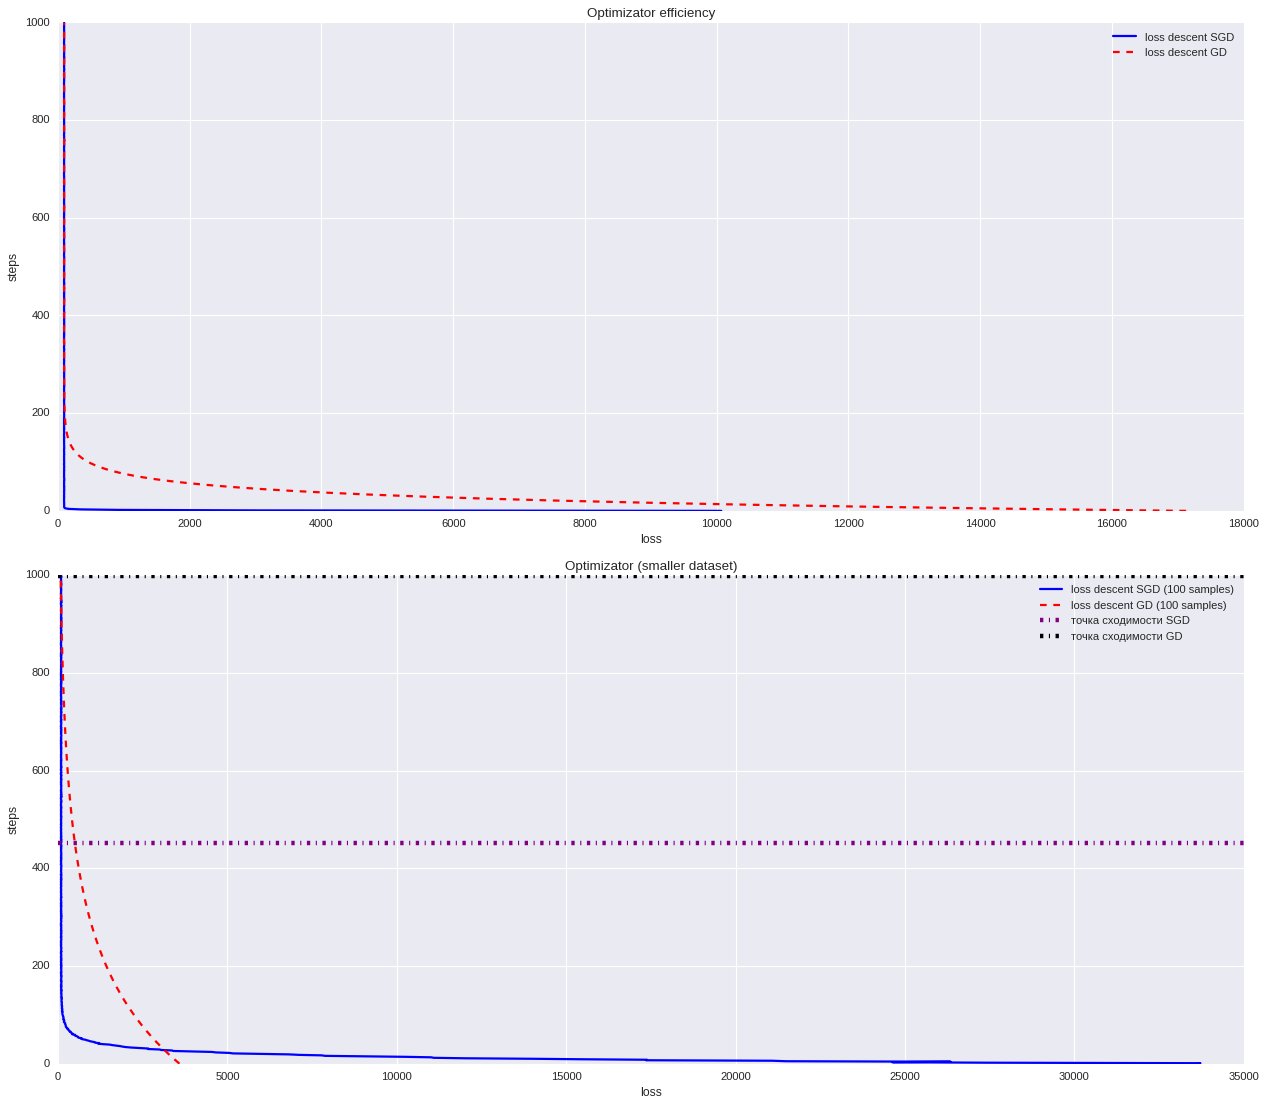

In [48]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-v0_8')
minimums = [[min(loss_sgd_tiny),loss_sgd_tiny.index(min(loss_sgd_tiny).item())],[min(loss_gd_tiny),loss_gd_tiny.index(min(loss_gd_tiny).item())]]

fig,ax = plt.subplots(2,1,figsize=(16,14))
ax[0].plot(loss_sgd,np.arange(1000),label = 'loss descent SGD',c='blue',linestyle='-',linewidth=2)
ax[0].plot(loss_gd,np.arange(1000),label = 'loss descent GD',c='red',linestyle='--',linewidth=2)
ax[0].set_title('Optimizator efficiency')
ax[0].set_xlabel('loss')
ax[0].set_ylabel('steps')
ax[0].legend()

ax[1].plot(loss_sgd_tiny,np.arange(1000),label = 'loss descent SGD (100 samples)',c='blue',linestyle='-',linewidth=2)
ax[1].plot(loss_gd_tiny,np.arange(1000),label = 'loss descent GD (100 samples)',c='red',linestyle='--',linewidth=2)
ax[1].set_title('Optimizator (smaller dataset)')
ax[1].set_xlabel('loss')
ax[1].set_ylabel('steps')
ax[1].axhline(minimums[0][1],c='purple',linestyle='-.',label='точка сходимости SGD',linewidth=4)
ax[1].axhline(minimums[1][1],c='black',linestyle='-.',label='точка сходимости GD',linewidth=4)
ax[1].legend()
plt.tight_layout()
plt.show()

999


In [12]:
loss_sgd_tiny.index(min(loss_sgd_tiny).item())

451

## Использовать стохастический градиентный спуск имеет практически всегда, но на очень маленьких датасетах обычный градиентный спуск может работать лучше

In [13]:
def sgd_momentum(X,y,theta,lr=0.01,batch_size=64,n_iter=1000,rturn_grads=None,draw = None,momentum=0.9):
  total_loss = []
  velocity = np.zeros_like(theta)
  for i in range(n_iter):
    step_loss = []
    for pos,(obj,trg) in enumerate(batch_generator(X,y,batch_size)):
      '''
      theta - веса инициализации
      '''
      trg_pred = obj @ theta
      error = sum((trg_pred-trg)**2)/len(obj)
      grad = 2*(obj.T @ (trg_pred-trg))/len(obj)
      step_loss.append(error)
      velocity = momentum*velocity + lr*grad
      theta = theta - velocity
    mean_step_loss = np.mean(step_loss)
    total_loss.append(mean_step_loss)
    if draw:
      print(f"Batch_iter: {i}, loss: {error}")
    if rturn_grads:
      print(f"grads : {grad}")
  return total_loss

In [14]:
loss_sgdm = sgd_momentum(X,y,w,batch_size=32,draw=False,momentum=0.9)
loss_sgdm_tiny = sgd_momentum(X_tiny,y_tiny,w,lr=0.01,momentum=0.9)

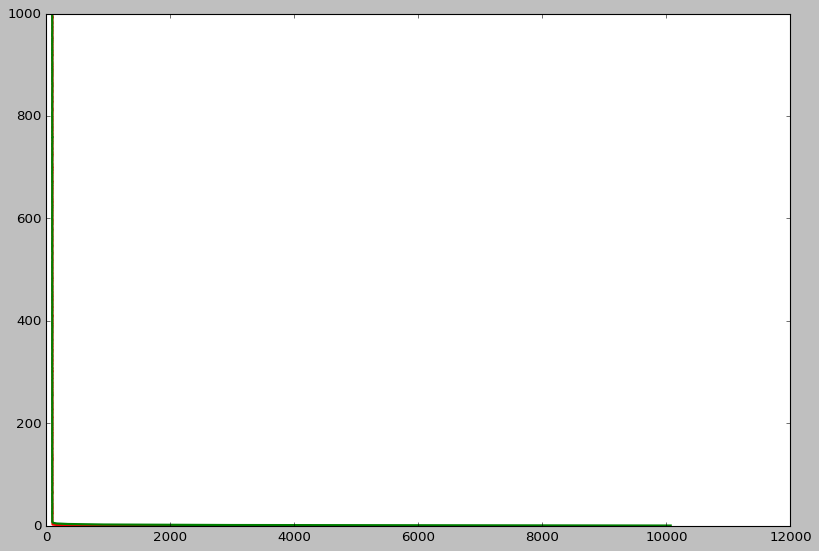

In [15]:
plt.figure(figsize=(12,8))
plt.plot(loss_sgdm,np.arange(1000),c='red',linewidth=2)
plt.plot(loss_sgd,np.arange(1000),c='green',linewidth=2)

Видно что около 0 на оси x, SGD ( momentum ) сходится чуть быстрее